In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18,12)
mpl.rcParams['axes.grid'] = False
sns.set_style('whitegrid')

import torch
import torch.nn as nn

In [2]:
# Upload the data frame into the notebook
data_frame = pd.read_csv('Data/learn_noise_siso2_2.csv', usecols=["Y","U"])
test_frame = pd.read_csv('Data/test_jump_siso2_2.csv', usecols=["Y","U"])
prediction_test_frame = pd.read_csv('Data/test_jump_siso2_2.csv', nrows=6, usecols=["Y","U"])

In [3]:
display(data_frame.head(10))

,Y,U
0,0.000000,0.354060
1,0.000000,-0.099556
2,-0.099556,-0.447062
3,-0.447062,0.367222
4,0.323622,0.393171
5,0.342267,0.296812
6,0.365017,-0.258941
7,-0.196087,0.166213
8,0.152555,-0.384891
9,-0.536536,-0.361935


In [4]:
# Defining a batch size based on the data
batch_size = 100

# Split the dataset into different batches
batch_data = np.array_split(data_frame, int(data_frame.shape[0]/batch_size))

# Shifting batch number 5 to the end to be used as a test data
# batch_data.append(batch_data.pop(1))

# Combining all the batches to form a single dataset
df = pd.DataFrame(np.concatenate(batch_data),columns=list(data_frame.columns))

C:\Users\piotr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [5]:
batch_data

[            Y         U
 0    0.000000  0.354060
 1    0.000000 -0.099556
 2   -0.099556 -0.447062
 3   -0.447062  0.367222
 4    0.323622  0.393171
 ..        ...       ...
 96   0.200555  0.083432
 97   0.194574 -0.389930
 98  -0.254192 -0.377131
 99  -0.382647  0.136357
 100  0.123254  0.066915
 
 [101 rows x 2 columns],
             Y         U
 101 -0.031247  0.204073
 102  0.133974  0.390458
 103  0.265196  0.240475
 104  0.408699  0.024325
 105  0.101454  0.152577
 ..        ...       ...
 197  0.069377  0.369579
 198  0.268372 -0.237647
 199  0.013783 -0.089960
 200 -0.009780 -0.179709
 201 -0.182636 -0.276240
 
 [101 rows x 2 columns],
             Y         U
 202 -0.262762 -0.117176
 203 -0.113578 -0.356254
 204 -0.298317 -0.191943
 205 -0.198577 -0.542761
 206 -0.526971  0.278080
 ..        ...       ...
 297 -0.405741  0.402900
 298  0.432244  0.442510
 299  0.392816  0.268559
 300  0.317021 -0.146055
 301 -0.087711  0.059755
 
 [100 rows x 2 columns],
             Y     

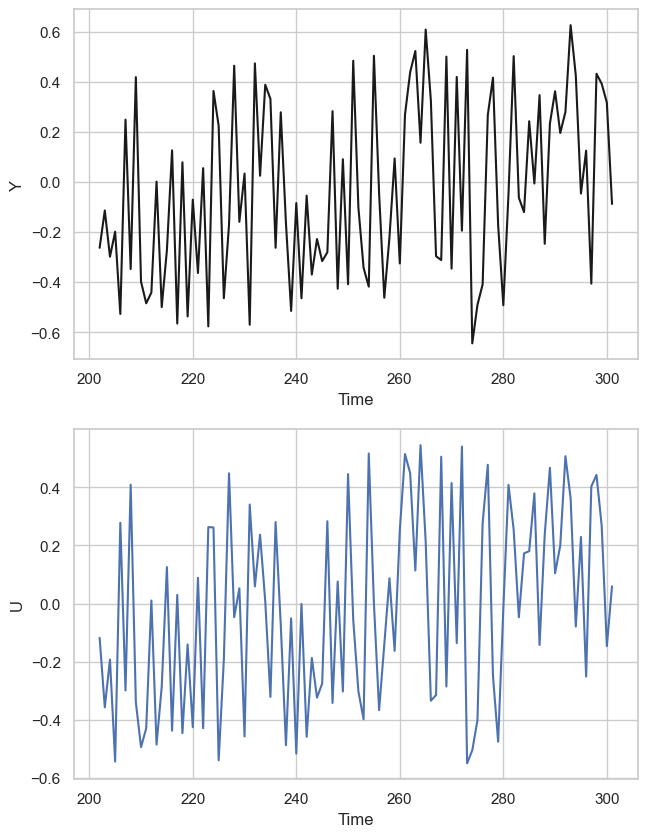

In [7]:
# Plotting the test data batch
fig = plt.figure(figsize=(16,10))

batch_no = 3

plt.subplot(2, 2, 1)
plt.plot(batch_data[batch_no-1]['Y'],'k')
plt.xlabel('Time')
plt.ylabel('Y')


plt.subplot(2, 2, 3)
plt.plot(batch_data[batch_no-1]['U'],'b')
plt.xlabel('Time')
plt.ylabel('U')


plt.show()

In [8]:
# Define a test size
test_size = batch_size

y = df.values.astype(float)
y_test = test_frame.values.astype(float)
y_pred_test = prediction_test_frame.values.astype(float)

# Create train and test sets
train_set = y
test_set = y_test
pred_test_set = y_pred_test
print(train_set[0:8])
# Convert train set into a torch tensor
train_set = torch.FloatTensor(train_set).view(-1,df.shape[1])
test_set = torch.FloatTensor(test_set).view(-1,df.shape[1])
pred_test_set= torch.FloatTensor(pred_test_set).view(-1,df.shape[1])

[[ 0.          0.35405963]
 [ 0.         -0.09955609]
 [-0.09955609 -0.44706172]
 [-0.44706172  0.36722226]
 [ 0.32362169  0.39317104]
 [ 0.34226659  0.2968121 ]
 [ 0.36501651 -0.25894074]
 [-0.19608727  0.16621282]]


In [9]:
# Creating a function to generate the input data for the lstm 
def input_data(seq,ws):
    
    inp_data = []
    
    for bat in range(0,train_set.shape[0],batch_size):
        
        bat_seq = seq[bat:bat+101]
        l = len(bat_seq)
        
        window = []
        label = []
        
        for i in range(l-ws):
        
            window = bat_seq[i:i+ws]
            label = bat_seq[i+ws:i+ws+1,:2]

            inp_data.append((window,label))
        
    return inp_data

In [10]:
# Defining a window size for prediction
window_size = 1
train_data = input_data(train_set,window_size)
print(train_data)

[(tensor([[0.0000, 0.3541]]), tensor([[ 0.0000, -0.0996]])), (tensor([[ 0.0000, -0.0996]]), tensor([[-0.0996, -0.4471]])), (tensor([[-0.0996, -0.4471]]), tensor([[-0.4471,  0.3672]])), (tensor([[-0.4471,  0.3672]]), tensor([[0.3236, 0.3932]])), (tensor([[0.3236, 0.3932]]), tensor([[0.3423, 0.2968]])), (tensor([[0.3423, 0.2968]]), tensor([[ 0.3650, -0.2589]])), (tensor([[ 0.3650, -0.2589]]), tensor([[-0.1961,  0.1662]])), (tensor([[-0.1961,  0.1662]]), tensor([[ 0.1526, -0.3849]])), (tensor([[ 0.1526, -0.3849]]), tensor([[-0.5365, -0.3619]])), (tensor([[-0.5365, -0.3619]]), tensor([[-0.3238,  0.3209]])), (tensor([[-0.3238,  0.3209]]), tensor([[0.3176, 0.2710]])), (tensor([[0.3176, 0.2710]]), tensor([[ 0.2006, -0.2494]])), (tensor([[ 0.2006, -0.2494]]), tensor([[-0.1601,  0.0648]])), (tensor([[-0.1601,  0.0648]]), tensor([[ 0.0255, -0.2908]])), (tensor([[ 0.0255, -0.2908]]), tensor([[-0.3812, -0.5291]])), (tensor([[-0.3812, -0.5291]]), tensor([[-0.4788, -0.3664]])), (tensor([[-0.4788, -0

In [11]:
from classy import LSTMModel

# Creating a model instance, loss function and the optimizer
model = LSTMModel(input_size=2,hidden_size_1=50,hidden_size_2=50,out_size=1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.005)

In [12]:
display(model)

LSTMModel(
  (lstm_1): LSTM(2, 50, batch_first=True)
  (lstm_2): LSTM(50, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [13]:
display(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [14]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   400
 10000
   200
   200
 10000
 10000
   200
   200
    50
     1
______
 31251


In [15]:
# Set the number of epochs

epochs = 200
previous_errors = []
max_epochs_witch_no_improvment = 3

for epoch in range(epochs):
    
    # Running each batch separately 
    
    for bat in range(0,1400,100):
    
        for seq,label in train_data[bat:bat+100]:
            
            # set the optimization gradient to zero

            optimizer.zero_grad()
            
            # initialize the hidden states

            model.hidden_1 = (torch.zeros(1,1,model.hidden_size_1),
                            torch.zeros(1,1,model.hidden_size_1))

            model.hidden_2 = (torch.zeros(1,1,model.hidden_size_2),
                            torch.zeros(1,1,model.hidden_size_2))
            
            # Make predictions on the current sequence

            y_pred = model(seq)
            
            # Compute the loss

            loss = criterion(y_pred, label)
            
            # Perform back propogation and gradient descent

            loss.backward()

            optimizer.step()

    if epoch%10 == 0:
        epochs_w_no_improv = 0
        for err in previous_errors:
            if err == loss.item():
                epochs_w_no_improv+=1
            if epochs_w_no_improv == max_epochs_witch_no_improvment:
                break
        previous_errors.insert(0,loss.item())
        print(f'Epoch: {epoch} Loss: {loss.item()}')

C:\Users\piotr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 Loss: 0.06300289183855057
Epoch: 10 Loss: 0.07471403479576111
Epoch: 20 Loss: 0.07128813117742538
Epoch: 30 Loss: 0.06741055846214294
Epoch: 40 Loss: 0.07044554501771927
Epoch: 50 Loss: 0.07228072732686996
Epoch: 60 Loss: 0.07138563692569733
Epoch: 70 Loss: 0.07093945890665054
Epoch: 80 Loss: 0.07248944044113159
Epoch: 90 Loss: 0.07054807990789413
Epoch: 100 Loss: 0.06919558346271515
Epoch: 110 Loss: 0.06749773025512695
Epoch: 120 Loss: 0.06672683358192444
Epoch: 130 Loss: 0.06601912528276443
Epoch: 140 Loss: 0.06626757234334946
Epoch: 150 Loss: 0.06737372279167175
Epoch: 160 Loss: 0.06893117725849152
Epoch: 170 Loss: 0.06725700944662094
Epoch: 180 Loss: 0.06930836290121078
Epoch: 190 Loss: 0.06848322600126266


In [16]:
future = 100

# Set the model to evaluation mode

model.eval()

preds = [test_set[0,:1].reshape(-1,1)]
print(test_set[0,:1])
print(preds)
for i in range(future-1):
    
    seq = test_set[i].reshape(-1,2)
    
    # Informing PyTorch that I am no longer interested in the gradients
    
    with torch.no_grad():
        
        # Initialize the hidden states
        
        model.hidden_1 = (torch.zeros(1,1,model.hidden_size_1),
                        torch.zeros(1,1,model.hidden_size_1))
        model.hidden_2 = (torch.zeros(1,1,model.hidden_size_2),
                        torch.zeros(1,1,model.hidden_size_2))
        
        preds.append(model(seq))
print(preds)       

tensor([0.])
[tensor([[0.]])]
[tensor([[0.]]), tensor([[-0.0564]]), tensor([[0.1685]]), tensor([[0.1241]]), tensor([[0.1241]]), tensor([[-0.0325]]), tensor([[-0.0257]]), tensor([[0.0727]]), tensor([[0.0562]]), tensor([[0.0217]]), tensor([[0.0400]]), tensor([[0.0512]]), tensor([[0.0416]]), tensor([[0.0386]]), tensor([[0.0438]]), tensor([[0.0440]]), tensor([[0.0416]]), tensor([[0.0421]]), tensor([[0.0430]]), tensor([[0.0426]]), tensor([[0.0423]]), tensor([[0.0425]]), tensor([[0.0426]]), tensor([[0.0425]]), tensor([[0.0425]]), tensor([[0.0426]]), tensor([[0.0425]]), tensor([[0.0425]]), tensor([[0.0425]]), tensor([[0.0425]]), tensor([[0.0425]]), tensor([[0.0425]]), tensor([[0.0425]]), tensor([[0.0425]]), tensor([[0.0425]]), tensor([[0.0425]]), tensor([[0.0425]]), tensor([[0.0425]]), tensor([[0.0425]]), tensor([[0.0425]]), tensor([[0.0425]]), tensor([[0.0425]]), tensor([[0.0425]]), tensor([[0.0425]]), tensor([[0.0425]]), tensor([[0.0425]]), tensor([[0.0425]]), tensor([[0.0425]]), tensor([[0

In [17]:
predictions = np.array([pred.numpy() for pred in preds]).reshape(-1,1)
true_values = np.array(test_set[:,:1])

Text(0, 0.5, 'x1')

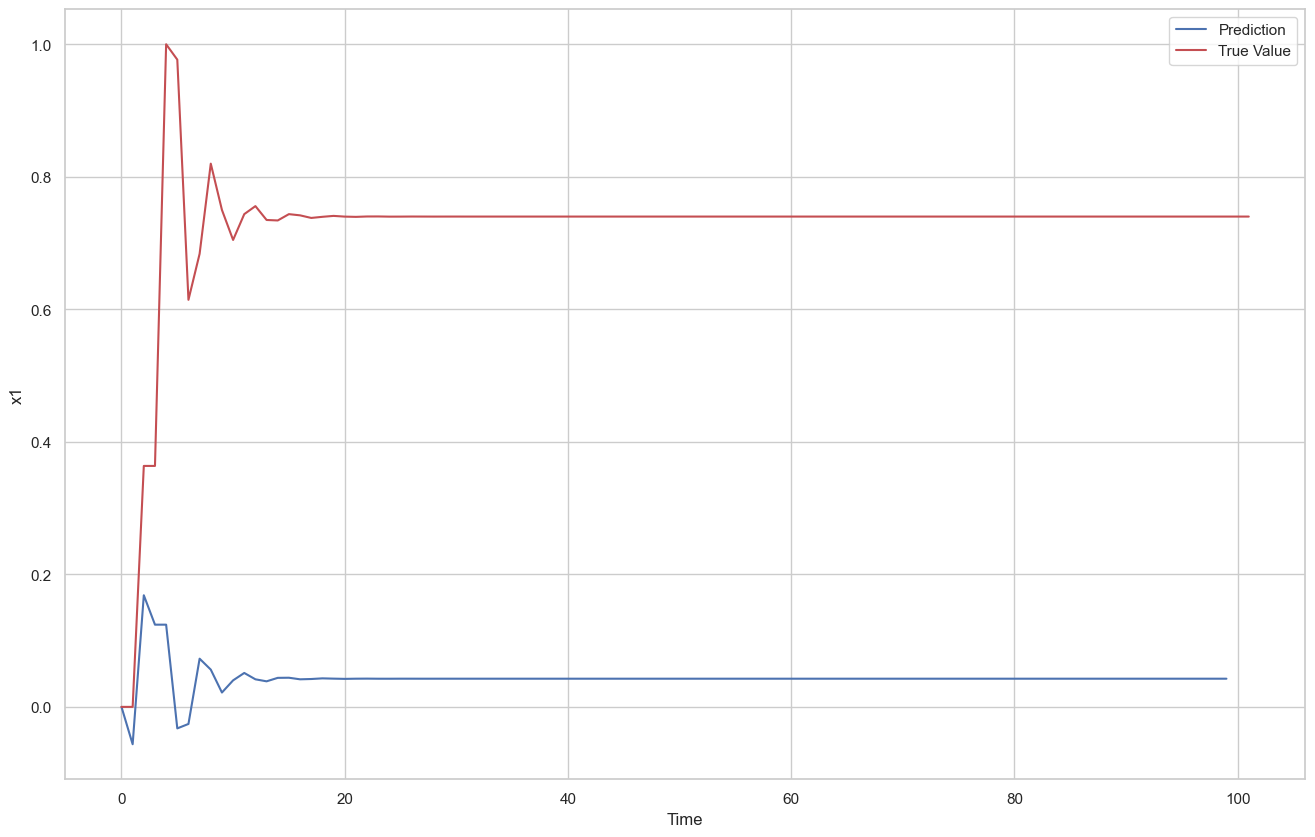

In [18]:
fig = plt.figure(figsize=(16,10))

plt.plot(predictions[:,0],'b',label='Prediction')
plt.plot(true_values[:,0],'r',label='True Value')
plt.legend()
plt.xlabel('Time')
plt.ylabel('x1')

In [19]:
RMSE = np.sqrt(np.sum(np.square((predictions - true_values[:,0])))/predictions.size)
display(RMSE)

6.969259020086891

In [20]:
future=100

preds = [test_set[0,:1].reshape(-1,1)]
print(test_set[0,:1])
print(preds)

for i in range(future-1):
    if i < len(pred_test_set):
        seq = test_set[i].reshape(-1, 2)
    else:
        x = torch.FloatTensor(preds[-1])  # Assuming preds[-1] contains the last prediction
        y = 1.0
        seq = torch.FloatTensor([x, y]).view(-1, df.shape[1])
            
    # Check if the sequence length is greater than 0
    if seq.size(0) > 0:
        # Informing PyTorch that I am no longer interested in the gradients
        with torch.no_grad():
            # Initialize the hidden states
            model.hidden_1 = (torch.zeros(1, 1, model.hidden_size_1),
                              torch.zeros(1, 1, model.hidden_size_1))
            model.hidden_2 = (torch.zeros(1, 1, model.hidden_size_2),
                              torch.zeros(1, 1, model.hidden_size_2))
            
            preds.append(model(seq))

tensor([0.])
[tensor([[0.]])]


In [21]:
predictions2 = np.array([pred.numpy() for pred in preds]).reshape(-1,1)
true_values = np.array(test_set[:,:1])

Text(0, 0.5, 'x1')

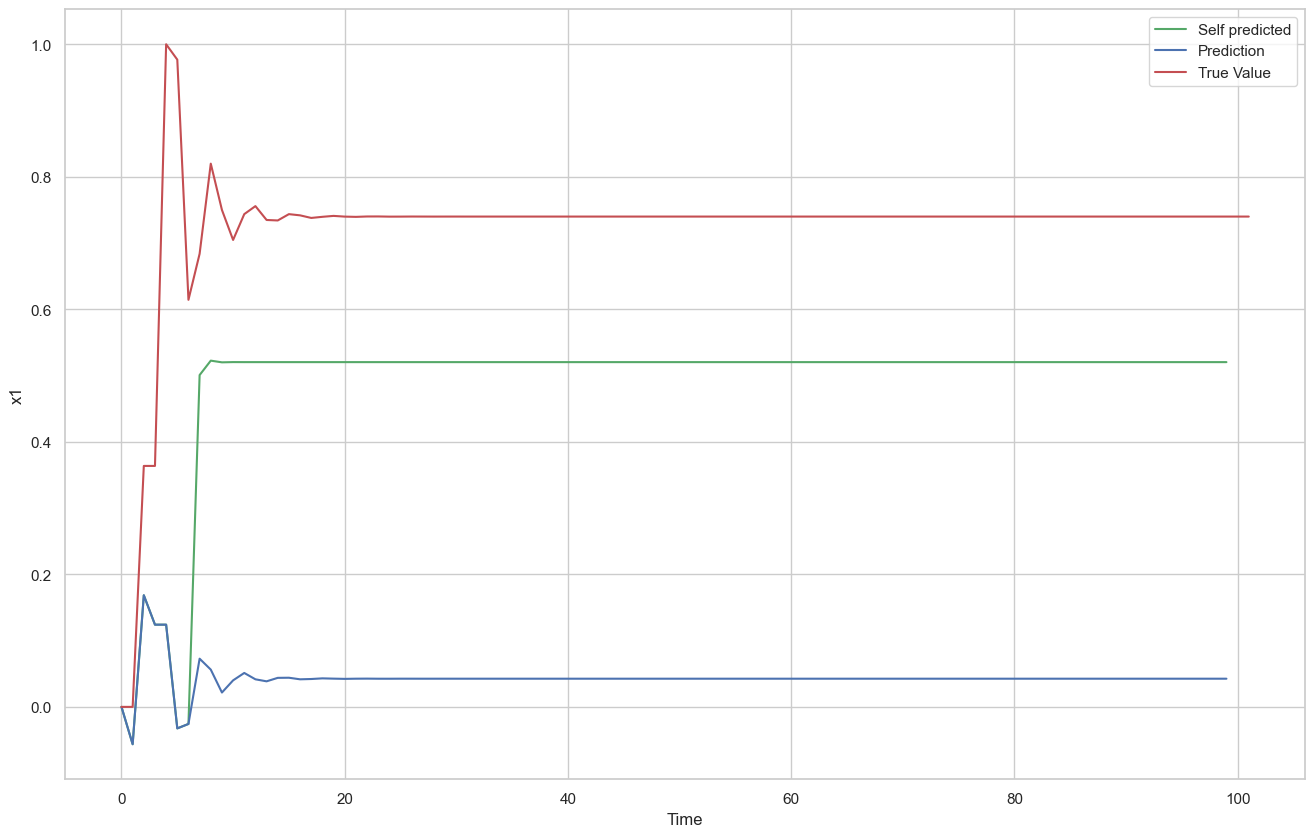

In [22]:
fig = plt.figure(figsize=(16,10))
plt.plot(predictions2[:,0],'g',label='Self predicted')
plt.plot(predictions[:,0],'b',label='Prediction')
plt.plot(true_values[:,0],'r',label='True Value')
plt.legend()
plt.xlabel('Time')
plt.ylabel('x1')